# Nonlinear Smoothing: Noisy Pendulum

In this demo, we will look at a realistic dynamical system with nonlinear state transitions: tracking a noisy single pendulum.
We translate a differential equation in state-space model form to a probabilistic model.

We are tracking a pendulum with noisy observations.
You can find this example in [Bayesian Filtering & Smoothing](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67) by Simon Särkkä (Ex 3.7).
Its state transitions are sinusoidal in nature and it hence, qualifies as a nonlinear dynamical system.


We can describe the system with the following differential equation:

$$\begin{align*}
\frac{d}{dt} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} x_2 \\ -g \sin(x_1) \end{bmatrix}
\end{align*}$$

where $x_1$ represents the angle $\alpha$ of the pendulum, $x_2$ represents the change in angle $d \alpha /dt$ and $g$ is gravitational acceleration.

We discretise the equation using a forward finite difference: $dx/dt = (x_{t+1} - x_{t})/\Delta t$. This produces the following discrete state transition:

$$\begin{align*}
\begin{bmatrix} x_{1,t+1} \\ x_{2,t+1} \end{bmatrix} = \begin{bmatrix} x_{1,t} + x_{2,t}\Delta t \\ x_{2,t} - g \sin(x_{1,t})\Delta t \end{bmatrix}
\end{align*}$$

We cannot observe the change in angle directly, only the angle itself (i.e. $x_{1}$).
We can select the first element of the state vector by taking the inner product between the vector $[1 \ 0]$ and the state vector $x_t$.

The observation is corrupted by white noise $v_t$:

$$y_t = x_{1,t} + v_t$$

where the white noise is sampled from a zero-mean Gaussian with precision $\tau^{-1}$:

$$v_t \sim \mathcal{N}(0, \tau^{-1}).$$

In [1]:
# Import libraries to julia workspace
using Rocket
using GraphPPL
using ReactiveMP
using Plots 
using Distributions

### Generate data

In [3]:
# Dimension: time
T = 500 # interaction: total time step count == time-series: length
Δt = 0.01 # time step: duration
rT = (1:T).*Δt

# Gravitational acceleration (SI: LT⁻²)
G = 9.81

# Measurement noise precision
noise_precision = 10.

# Initial states
x0 = [1.0, 0.0]

# Initialize data array
states = zeros(2,T)
observations = zeros(T,)

# Initialize previous state variable
prev_state = x0

for t = 1:T
    # State transition
    states[1,t] = prev_state[1] + prev_state[2]*Δt
    states[2,t] = prev_state[2] - G*sin(prev_state[1])*Δt
    
    # Observation likelihood
    observations[t] = states[1,t] + sqrt(inv(noise_precision))*randn(1)[1]
    
    # Update "previous state"
    prev_state = states[:,t]
end    

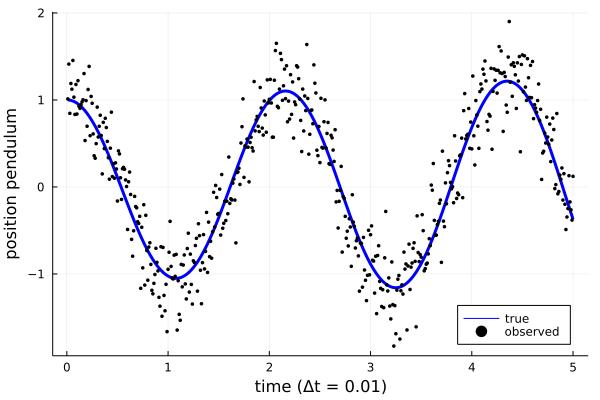

In [4]:
# Inspect data
plot(rT, states[1,:], linewidth=3, color="blue", xlabel="time (Δt = "*string(Δt)*")", ylabel="position pendulum", label="true", legend=:bottomright)
scatter!(rT, observations, color="black", markersize=2,label="observed")

In [5]:
# model of the nonlinear state transitions
g(x) = [x[1] + x[2]*Δt, x[2] - G*sin(x[1])*Δt]

τ_prior = Gamma(1.0, 1.0)

# model of the complete system dynamics
@model function noisy_pendulum(n, τ_prior=Gamma(1.0, 1.0))
    y = datavar(Float64, n)
    x = randomvar(n)
    
    τ ~ Gamma(α=τ_prior.α, β=τ_prior.θ)
    x_0 ~ MvNormal(μ=zeros(2), Σ=diageye(2))
    
    x_prev = x_0
    for i in 1:n
        x[i] ~ g(x_prev) where {meta=UT()}
        y[i] ~ Normal(μ=dot([1.0, 0.0], x[i]), γ=τ)
        x_prev = x[i]
    end
    
end
# assumed factorization of the recognition model
constraints = @constraints begin 
    q(x_0, x, τ) = q(x_0, x)q(τ)
end

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(x_0, x, τ) = q(x_0, x)q(τ)
Options:
  warn = true


In [6]:
n = length(observations)
imarginals = (τ = τ_prior, )
result = inference(model = Model(noisy_pendulum, n, τ_prior), iterations=10, options=(limit_stack_depth=100, ), constraints=constraints, initmarginals=imarginals, data=(y=observations,), free_energy=true, showprogress=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Inference results:
-----------------------------------------
Free Energy: Real[122.191, 113.492, 113.486, 113.486, 113.486, 113.486, 113.486, 113.486, 113.486, 113.486]
-----------------------------------------
x_0 = MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNorma...
τ   = GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=251.0, b=23.485754326556464), ...
x   = Vector{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}...


In [7]:
result.posteriors[:τ]

10-element Vector{GammaShapeRate{Float64}}:
 GammaShapeRate{Float64}(a=251.0, b=23.485754326556464)
 GammaShapeRate{Float64}(a=251.0, b=22.476277526866898)
 GammaShapeRate{Float64}(a=251.0, b=22.471782557942305)
 GammaShapeRate{Float64}(a=251.0, b=22.471762540754)
 GammaShapeRate{Float64}(a=251.0, b=22.47176245551164)
 GammaShapeRate{Float64}(a=251.0, b=22.471762454444452)
 GammaShapeRate{Float64}(a=251.0, b=22.471762449943157)
 GammaShapeRate{Float64}(a=251.0, b=22.47176245824491)
 GammaShapeRate{Float64}(a=251.0, b=22.471762453533913)
 GammaShapeRate{Float64}(a=251.0, b=22.471762456081656)

In [8]:
result.posteriors[:x]

10-element Vector{Vector{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}}:
 [MvNormalWeightedMeanPrecision(
xi: [994.016356677586, 137.25469369668193]
Λ: [1015.48898036491 145.5264955512486; 145.5264955512486 40.643291117933174]
)
, MvNormalWeightedMeanPrecision(
xi: [1011.0445189492699, 128.8379032799784]
Λ: [1044.4452812479872 139.94964339197065; 139.94964339197065 38.15553308447852]
)
, MvNormalWeightedMeanPrecision(
xi: [1022.9095109388666, 119.64164031300983]
Λ: [1067.0346434790563 133.09341247820205; 133.09341247820205 35.74596401132928]
)
, MvNormalWeightedMeanPrecision(
xi: [1031.462057851396, 109.64344530501535]
Λ: [1086.0944189056377 125.20629195488881; 125.20629195488881 33.31106637866849]
)
, MvNormalWeightedMeanPrecision(
xi: [1037.3399690518813, 99.18785779700553]
Λ: [1101.893796857463 116.5834093599559; 116.5834093599559 30.98025241235039]
)
, MvNormalWeightedMeanPrecision(
xi: [1041.5220410272825, 88.4724852817959]
Λ: [1115.4082048494872 107.44

In [9]:
result.posteriors[:x_0]

10-element Vector{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}:
 MvNormalWeightedMeanPrecision(
xi: [980.5516757140421, 147.19485726343828]
Λ: [987.3278263771381 151.55151838069577; 151.55151838069577 43.65536992699175]
)

 MvNormalWeightedMeanPrecision(
xi: [11615.75843600847, 1718.1095264327887]
Λ: [11545.967752472861 1716.0043682725657; 1716.0043682725657 454.5069922137875]
)

 MvNormalWeightedMeanPrecision(
xi: [12148.230727608974, 1797.180544880425]
Λ: [12074.346556984803 1794.6431132589473; 1794.6431132589473 475.0895770396979]
)

 MvNormalWeightedMeanPrecision(
xi: [12150.709002433756, 1797.5485788667092]
Λ: [12076.805762607133 1795.009129786409; 1795.009129786409 475.18537240123595]
)

 MvNormalWeightedMeanPrecision(
xi: [12150.720090173372, 1797.5502291641026]
Λ: [12076.81674496275 1795.0107685005548; 1795.0107685005548 475.185801028489]
)

 MvNormalWeightedMeanPrecision(
xi: [12150.720098802543, 1797.5502326479825]
Λ: [12076.816757991055 1795.0107

In [10]:
m_x_t = mean.(result.posteriors[:x][end]) 
v_x_t = cov.(result.posteriors[:x][end]);

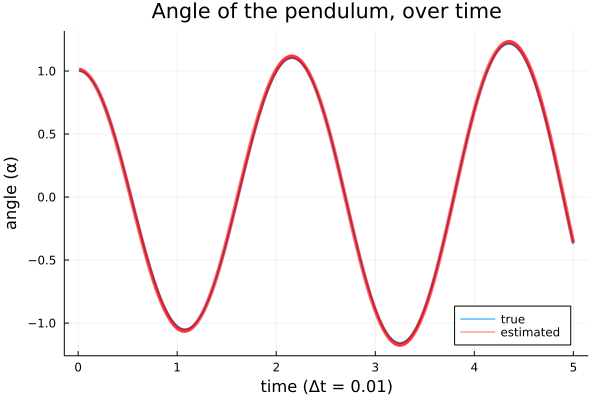

In [11]:
# Plot true states and overlay estimates
plot(rT, states[1,:], linewidth=2, xlabel="time (Δt = "*string(Δt)*")", ylabel="angle (α)", label="true", legend=:bottomright)
plot!(rT, first.(m_x_t), linewidth=4, color="red", ribbon=sqrt.(first.(v_x_t)), alpha=0.6, label="estimated")
title!("Angle of the pendulum, over time")

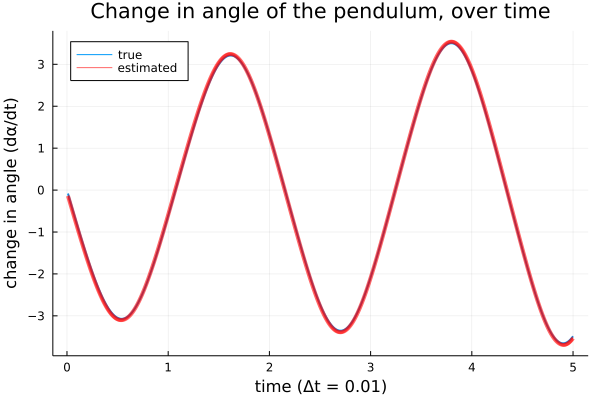

In [12]:
# Plot true states and overlay estimates
plot(rT, states[2,:], linewidth=2, xlabel="time (Δt = "*string(Δt)*")", ylabel="change in angle (dα/dt)", label="true", legend=:topleft)
plot!(rT, last.(m_x_t), linewidth=4, color="red", ribbon=sqrt.(last.(v_x_t)), alpha=0.6, label="estimated")
title!("Change in angle of the pendulum, over time")

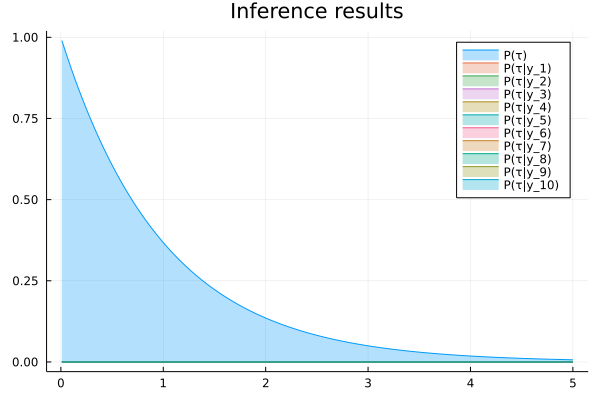

In [15]:
plot(title = "Inference results")
plot!(rT, (x) -> pdf(τ_prior, x), fillalpha=0.3, fillrange = 0, label="P(τ)")
for (i,τ̂) in enumerate(result.posteriors[:τ])
    plot!(rT, (x) -> pdf(Gamma(τ̂.a,τ̂.b), x), fillalpha=0.3, fillrange = 0, label="P(τ|y_$i)")
end
plot!()

It is important to look at the evolution of free energy. Remember that free energy is a measure of uncertainty-weighted prediction error. 

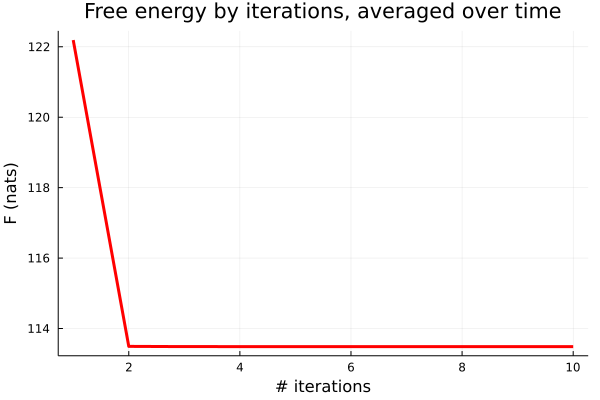

In [14]:
# Plot free energy objective
plot(result.free_energy, linewidth=3, color="red", xlabel="# iterations", ylabel="F (nats)", label="")
title!("Free energy by iterations, averaged over time")